In [253]:
import numpy as np
from scipy.ndimage import gaussian_laplace, rank_filter, generic_filter
import skimage
import matplotlib.pyplot as plt
import cv2
import time

In [254]:
from matplotlib.patches import Circle
def show_all_circles(loc,image, cx, cy, sig, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, s in zip(cx, cy, sig):
        circ = Circle((x, y), s*(2**0.5), color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    #plt.savefig(loc)
    plt.show()

In [255]:
img_dir = "data/"
img_list = ["butterfly.jpg","einstein.jpg","sunflowers.jpg","fishes.jpg","2.jpg","cat.jpg","dog.jpg","dice.jpg"]

In [256]:
def increase_filter(img):
    start_time = time.time()
    h,w = img.shape
    sigma = 2.0
    k = 2**0.5
    scale_list = np.empty((h, w, 12))
    for i in range(12):
        normalized = sigma**2*gaussian_laplace(img,sigma)
        scale_list[:,:,i] = normalized**2
        sigma*= k
    end_time = time.time()
    print("increase filter",end_time-start_time)
    return scale_list

In [257]:
def downsample(img):
    start_time = time.time()
    h,w = img.shape
    k = 2**0.5
    sigma = 2.0
    scale_list = np.empty((h, w, 12))
    for i in range(12):
        img = skimage.transform.resize(img,(int(h/pow(k,i)), int(w/pow(k,i))))
        normalized = sigma**2*gaussian_laplace(img,sigma)
        scale_list[:,:,i]= skimage.transform.resize(normalized**2,(h,w))
    end_time = time.time()
    print("downsample",end_time-start_time)
    return scale_list    

In [258]:
def nms(scale_list):
    h,w,_ = scale_list.shape
    local_max = np.empty((h, w, 12))
    maxima = []
    for i in range(12):
        local_max[:,:,i] = rank_filter(input=scale_list[:,:,i],rank=-1,size=(3,3))
    # for i in range(12):
    #         maxx = lambda a:np.amax(a)
    #         local_max[:,:,i] = generic_filter(scale_list[:,:,i], maxx, (3, 3))
    for i in range(h):
        for j in range(w):
            maxx = max(local_max[i,j,:])
            idx = np.argmax(local_max[i,j,:])
            if maxx == scale_list[i][j][idx] and maxx >= 0.02:
                maxima.append((i,j,idx))
    
    cx,cy,sig = [],[],[]
    
    for i,j,level in maxima:
        cx.append(j)
        cy.append(i)
        sig.append(2.0*((2**0.5)**level))
        
    return cx,cy,sig
    

increase filter 0.6730060577392578
downsample 0.10200023651123047


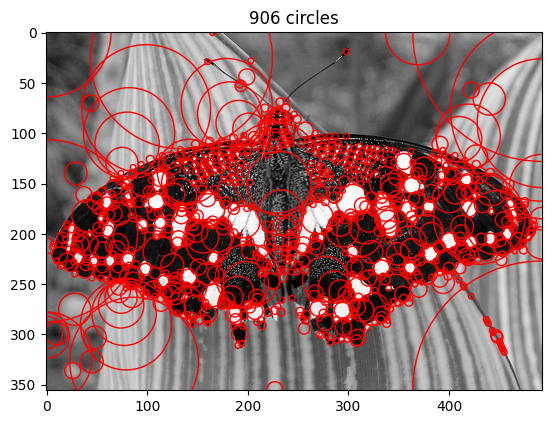

increase filter 1.1540071964263916
downsample 0.18301105499267578


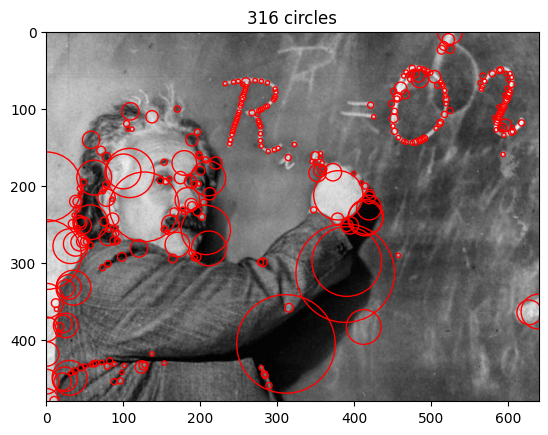

increase filter 0.44899845123291016
downsample 0.06700563430786133


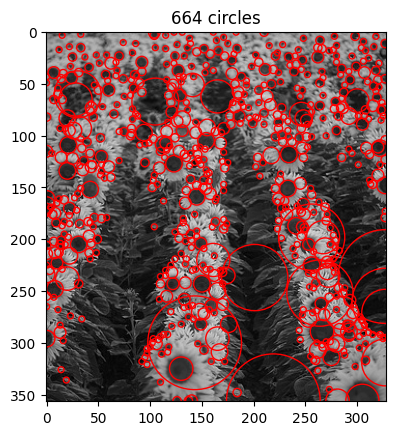

increase filter 0.7179656028747559
downsample 0.09901070594787598


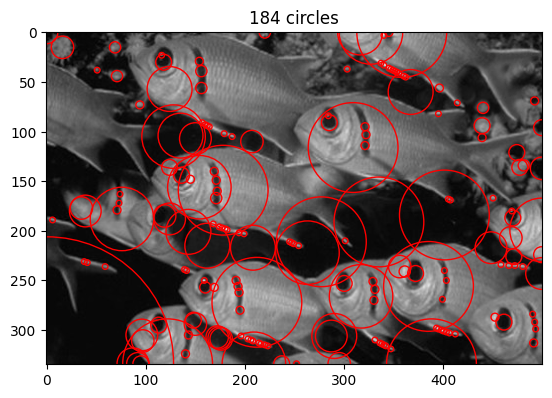

increase filter 0.6469857692718506
downsample 0.1049799919128418


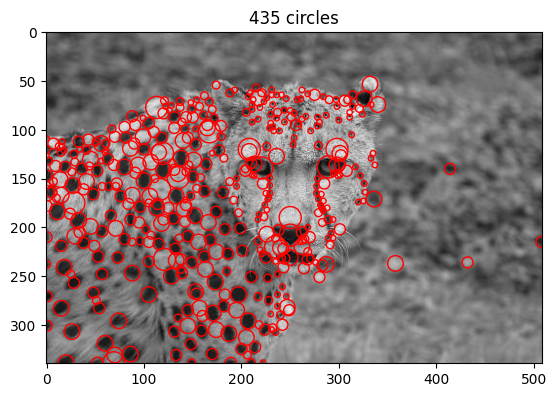

increase filter 0.7340471744537354
downsample 0.10900115966796875


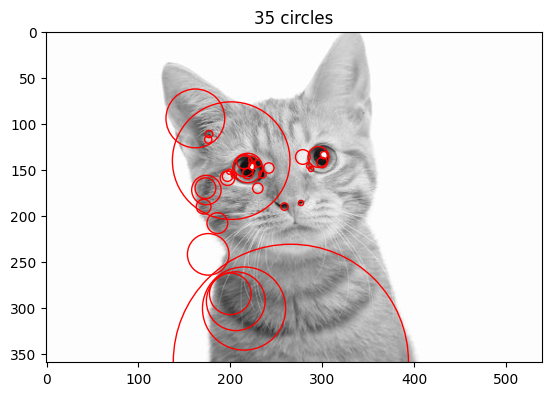

increase filter 1.0040061473846436
downsample 0.14499855041503906


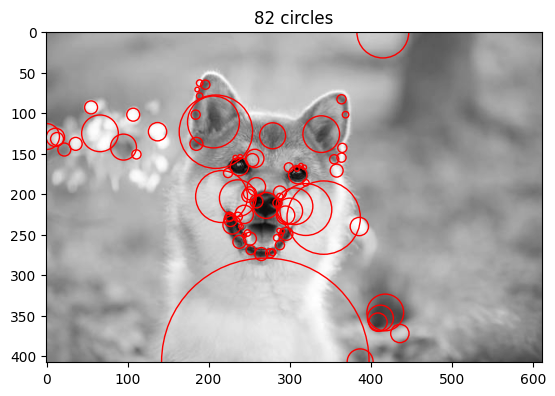

increase filter 0.33002614974975586
downsample 0.05199575424194336


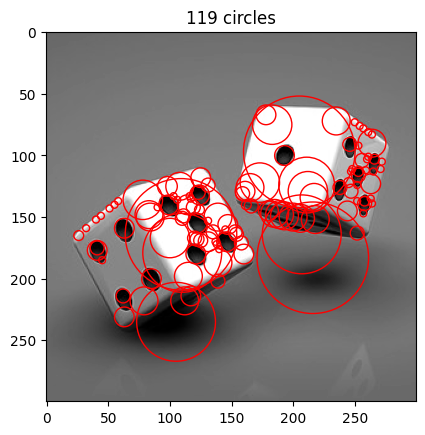

In [259]:
for loc in img_list:
    img = cv2.imread(img_dir+loc,cv2.IMREAD_GRAYSCALE).astype(np.float64)
    img/= 255
    cx,cy,sig = nms(increase_filter(img))
    _ = downsample(img)
    show_all_circles(loc,img,cx,cy,sig)
    